## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Import modules, set options

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


#### Filter

In [5]:
train_csv, _ = train_test_split(train_csv, test_size=0.99, random_state=42)

#### Train_CSV Params

In [6]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,46581.000000,46581.000000,46581.000000,46581.000000
mean,69273.949014,13.340826,5.897684,15.642241
std,36548.516161,3.261315,5.001572,34.728249
min,7.000000,2.000000,0.000000,-24.501900
25%,39222.000000,11.000000,2.000000,-0.288595
50%,71690.000000,13.000000,5.000000,2.245890
75%,100777.000000,16.000000,8.000000,7.274130
max,133884.000000,28.000000,26.000000,201.477997


In [7]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (46581, 5)
Total:  885423


Index                       372648
molecule_index              186324
atom_index_0                46581 
atom_index_1                46581 
type                        46965 
scalar_coupling_constant    186324
dtype: int64

In [8]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [9]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [10]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [11]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [12]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [13]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [14]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [15]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [16]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [17]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [18]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [19]:
def build_couple_dataframeOld(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    
    
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [20]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [21]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [22]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


## Check Regressions for a simple type

## New heading

In [40]:
def build_atoms(base_from, structures_from, n_atoms):
    base = base_from
    structures = structures_from

    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in atoms:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)

    add_center(atoms)

    atoms = merge_all_atoms(atoms, structures)

    add_distance_to_center(atoms)

    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
    #atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms = atoms.drop(['atom_index'], axis=1)
    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'x_c', 'y_c', 'z_c', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()

    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    return atoms

def build_coors(some_csv, structures_csv, coupling_type, n_atoms):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    
    atoms = build_atoms(base, structures, n_atoms)
    full = add_atoms(base, atoms)
    return full

#cylindrical coordinates (projection on the axis and distance to the axis)
def calc_cylindrical_coor(localCoor, axis):
    distAlongAxis =  np.dot(localCoor, axis)
    projectionOnAxis = axis * distAlongAxis
    vectorFromAxis = localCoor - projectionOnAxis    
    r = np.linalg.norm(vectorFromAxis)
    return distAlongAxis, r

#calculate inverse of cylindrical coordinates
def calc_inv_dist(row, suffix = 1):
    coor_center = np.array([row['x_c'], row['y_c'], row['z_c']])
    coor_0 = np.array([row['x_0'], row['y_0'], row['z_0']])
    coor_atom = np.array([row[f'x_{suffix}'], row[f'y_{suffix}'], row[f'z_{suffix}']])
    
    axis = coor_0 - coor_center
    axis = axis / np.linalg.norm(axis)    
    
    localCoor = coor_atom - coor_center
    
    distAlongAxis, r = calc_cylindrical_coor(localCoor, axis)
    
    invDistAlongAxis = 1 / distAlongAxis
    #invR = 1 / r
    invR =  r
    #row[f'dist_along_{suffix}'] = invDistAlongAxis
    #print(invDistAlongAxis, invR)
    return invDistAlongAxis
    
    
#calculate inverse of cylindrical coordinates
def calc_inv_r(row, suffix = 1):
    coor_center = np.array([row['x_c'], row['y_c'], row['z_c']])
    coor_0 = np.array([row['x_0'], row['y_0'], row['z_0']])
    coor_atom = np.array([row[f'x_{suffix}'], row[f'y_{suffix}'], row[f'z_{suffix}']])
    
    axis = coor_0 - coor_center
    axis = axis / np.linalg.norm(axis)    
    
    localCoor = coor_atom - coor_center
    
    distAlongAxis, r = calc_cylindrical_coor(localCoor, axis)
    
    invDistAlongAxis = 1 / distAlongAxis
    #invR = 1 / r
    invR =  r
    return invR
    
    

#add distances along axis
def add_axis_distances(df):
    filter_col = [col for col in df if col.startswith('x_')]
    n_atoms = len(filter_col) - 1
    #print(n_atoms)
    for i in range(1, n_atoms):           
            df[f'dist_along_{i}'] = df.apply(calc_inv_dist,  axis=1, args=[i])
    for i in range(2, n_atoms):                        
            df[f'r_{i}'] = df.apply(calc_inv_r,  axis=1, args=[i])

def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    full = build_coors(some_csv, structures_csv, coupling_type, n_atoms)
    add_axis_distances(full)
    full.sort_values('id', inplace=True)
    return full



In [41]:
%%time
molecule_index = 55
some_csv = train_csv[train_csv.molecule_index == molecule_index]
#some_csv = train_csv [:30000]
coupling_type = '1JHC'
n_atoms = 10
some_csv

#full = build_coors(some_csv, structures_csv, coupling_type, n_atoms)
#add_axis_distances(full)
full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms)
full.head()

Wall time: 95.8 ms


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9
0,814,55,11,3,82.591797,-1.938548,-0.199107,-0.918283,-1.420128,-0.549332,-0.02116,-1.679338,-0.37422,-0.469721,1,1,6,8,6,1,1,6,-1.399376,-1.988507,0.005068,0.625905,-0.00856,-0.514597,-0.522148,0.761377,-1.642591,-0.230597,0.007026,-0.483637,1.542701,1.907025,1.948825,-0.518392,-0.045638,0.857265,0.018562,-1.176571,0.001527,-0.897058,0.879183,1.247664,-1.828604,-1.127781,-1.116177,-0.928654,-1.825087,-1.770992,1.890648,-1.097619,-0.38289,1.039596,1.036553,1.43577,2.350646,2.523752,2.542353,2.779413,1.451282


## Break!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


In [34]:
aaaa

NameError: name 'aaaa' is not defined

## New heading

In [35]:
%%time
full = build_couple_dataframe(train_csv, structures_csv, '1JHC', n_atoms=10)
full.describe()

Wall time: 7.74 s


,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,x_c,y_c,z_c,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9
count,6.944000e+03,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6942.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6942.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6942.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6942.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6944.000000,6942.000000
mean,2.348972e+06,69694.462990,13.373128,3.366215,95.105049,0.104324,-0.150196,0.062424,0.121572,-0.165596,0.063114,0.112948,-0.157896,0.062769,2.517281,4.700173,5.770881,2.752160,3.569700,4.062788,4.118952,4.160282,0.148671,0.132994,0.110707,0.094936,0.104508,0.142236,0.131530,0.138341,-0.087725,-0.069756,-0.359061,-0.428380,-0.389418,-0.389571,-0.416588,-0.377855,0.074229,0.063107,0.031046,0.002244,0.027619,0.020398,0.054105,0.048153,-0.546469,-0.979082,-1.101287,-1.151992,-0.719991,-0.884150,-1.179842,-1.386189,-1.517307,1.078031,1.236380,1.450135,2.162223,2.190188,2.170258,2.202000,2.311781
std,1.346315e+06,36600.432974,3.317303,2.675598,18.535955,1.776995,2.151737,1.589480,1.453532,1.855396,1.242612,1.590326,1.988660,1.387182,2.582359,2.615770,1.354625,2.608511,2.778341,2.726176,2.728107,2.738037,1.677681,1.473215,1.341082,1.637617,1.552485,1.553878,1.541923,1.548252,2.067774,1.939039,1.634629,1.865234,1.821674,1.772508,1.751156,1.766747,1.516173,1.283531,1.089961,1.425860,1.385459,1.378788,1.404331,1.389141,0.003462,0.169761,0.295978,0.371873,0.758952,0.993173,1.137251,1.244407,1.314850,0.175435,0.219173,0.248870,0.364682,0.472160,0.608131,0.744295,0.839984
min,8.140000e+02,55.000000,5.000000,0.000000,71.109001,-6.691784,-8.922908,-6.935884,-6.204125,-7.864674,-6.046872,-6.435010,-8.393791,-6.491378,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,-6.846056,-6.947312,-7.735908,-7.011456,-6.368214,-7.134873,-6.176491,-5.860893,-7.234712,-7.028104,-6.831953,-7.796617,-6.664641,-7.279958,-7.421612,-6.965413,-6.624074,-6.412561,-5.542601,-6.541166,-6.378005,-5.219002,-5.633099,-6.129325,-0.570219,-1.740674,-3.216466,-4.312263,-5.770027,-6.876337,-8.326355,-8.720528,-8.721088,0.000016,0.000075,0.000302,0.000821,0.001357,0.000691,0.002832,0.011244
25%,1.200247e+06,39825.250000,11.000000,1.000000,84.155851,-0.903105,-1.787653,-0.950601,-0.392980,-1.493607,-0.419741,-0.595858,-1.622574,-0.607074,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.804044,-0.777919,-0.187787,-0.981591,-0.941392,-0.847206,-0.868561,-0.846584,-1.657338,-1.599674,-1.335547,-1.559594,-1.511908,-1.517764,-1.691914,-1.646737,-0.930830,-0.761930,-0.208092,-0.929210,-0.923053,-0.978197,-0.941005,-0.884998,-0.548082,-1.010226,-1.191687,-1.208080,-0.812951,-1.418166,-2.160787,-2.408067,-2.523401,1.035831,1.042519,1.372850,2.138459,2.096562,1.716325,1.576666,1.579770
50%,2.337007e+06,71784.000000,13.000000,3.000000,88.220947,0.089180,-0.214652,0.029923,0.037658,-0.244060,0.010608,0.124805,-0.245115,0.016324,1.000000,6.000000,6.000000,1.000000,1.000000,6.000000,6.000000,6.000000,0.106680,0.066274,0.029912,0.104926,0.105802,0.174895,0.156767,0.100037,-0.119517,-0.179732,-0.127237,-0.485015,-0.495143,-0.510319,-0.506049,-0.463135,0.028144,0.014773,0.007729,0.000960,0.0

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [27]:
def take_n_atomsO(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(1, n_atoms):
            labels.append(f'dist_along_{i}')
    for i in range(2, n_atoms):
            labels.append(f'r_{i}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    #atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    #output = output.drop(atoms_names, axis=1)
    return output

In [28]:
df = take_n_atoms(full, 10)
df.head()


,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,dist_along_1,dist_along_2,dist_along_3,dist_along_4,dist_along_5,dist_along_6,dist_along_7,dist_along_8,dist_along_9,r_2,r_3,r_4,r_5,r_6,r_7,r_8,r_9,scalar_coupling_constant
4343,1,1,6,8,6,1,1,6,-1.828604,-1.127781,-1.116177,-0.928654,-1.825087,-1.770992,1.890648,-1.097619,-0.382890,1.039596,1.036553,1.435770,2.350646,2.523752,2.542353,2.779413,1.451282,82.591797
3222,1,1,7,1,1,6,6,6,-1.815848,-1.133801,-1.120246,-0.858389,1.837554,0.711378,-2.219042,-1.673744,1.672183,1.043631,1.040338,1.318307,2.430525,2.069672,2.492364,2.528159,2.804663,89.906601
5063,1,1,8,6,1,1,6,7,-1.832854,-1.104045,-1.103970,-1.047041,-0.424984,-0.356402,-0.356455,-0.368917,-0.330440,1.040028,1.040004,1.352892,1.480402,1.338391,1.342922,2.902355,4.012683,85.027603
542,1,1,6,1,8,1,6,1,-1.828587,-1.125673,-1.117522,-0.926460,-1.335944,-1.643238,-0.458033,-0.953759,-1.392556,1.039061,1.037373,1.423118,2.158993,2.381221,1.422739,3.642234,4.013459,85.558296
5414,1,1,6,6,1,8,1,6,-1.825126,-1.158419,-1.091208,-0.929385,-1.540385,2.233624,-0.556258,-1.051753,-0.822545,1.049467,1.026260,1.423250,2.578610,2.629186,2.037650,2.782103,3.869808,83.160400


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [29]:
df = take_n_atoms(full, 9)

#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8',
       'dist_along_1', 'dist_along_2', 'dist_along_3', 'dist_along_4',
       'dist_along_5', 'dist_along_6', 'dist_along_7', 'dist_along_8', 'r_2',
       'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'scalar_coupling_constant'],
      dtype='object')

In [30]:
# df.hist(bins=10, figsize = [20,20] )

In [31]:
#df.plot.scatter(x='dist_along_1', y = 'scalar_coupling_constant') 

In [32]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5555, 22), (1389, 22), (5555,), (1389,))

## CatBoost

In [33]:
from catboost import CatBoostRegressor

In [34]:
CAT_PARAMS = {
          'learning_rate': 1,
           'max_depth': 3,    
           'n_estimators': 10
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 94.4735198	test: 95.1415487	best: 95.1415487 (0)	total: 60.9ms	remaining: 549ms
1:	learn: 93.9756103	test: 94.6435600	best: 94.6435600 (1)	total: 66.8ms	remaining: 267ms
2:	learn: 93.4772161	test: 94.1452454	best: 94.1452454 (2)	total: 71.9ms	remaining: 168ms
3:	learn: 92.9793651	test: 93.6473689	best: 93.6473689 (3)	total: 77.7ms	remaining: 117ms
4:	learn: 92.4809351	test: 93.1487809	best: 93.1487809 (4)	total: 83ms	remaining: 83ms
5:	learn: 91.9830804	test: 92.6508893	best: 92.6508893 (5)	total: 88.1ms	remaining: 58.7ms
6:	learn: 91.4844905	test: 92.1522173	best: 92.1522173 (6)	total: 93.5ms	remaining: 40.1ms
7:	learn: 90.9865748	test: 91.6545719	best: 91.6545719 (7)	total: 98.8ms	remaining: 24.7ms
8:	learn: 90.4887021	test: 91.1566819	best: 91.1566819 (8)	total: 104ms	remaining: 11.5ms
9:	learn: 89.9908481	test: 90.6588751	best: 90.6588751 (9)	total: 109ms	remaining: 0us

bestTest = 90.65887513
bestIteration = 9



4.507103837856882

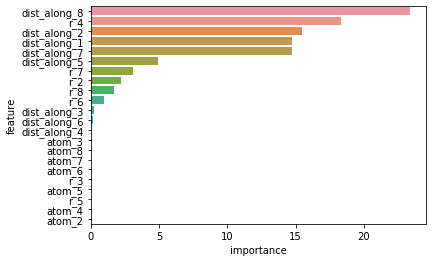

In [35]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

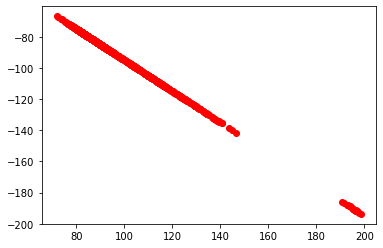

In [36]:
plt.plot(y_val, y_pred - y_val, 'ro')

## LGBMRegressor

In [37]:
#aaa

In [38]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [39]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=10000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.77227	valid_1's l1: 2.95107
[200]	training's l1: 2.43006	valid_1's l1: 2.69416
[300]	training's l1: 2.26595	valid_1's l1: 2.57452
[400]	training's l1: 2.15554	valid_1's l1: 2.49129
[500]	training's l1: 2.07039	valid_1's l1: 2.43565
[600]	training's l1: 1.99402	valid_1's l1: 2.39277
[700]	training's l1: 1.92244	valid_1's l1: 2.36133
[800]	training's l1: 1.86823	valid_1's l1: 2.33361
[900]	training's l1: 1.8172	valid_1's l1: 2.31075
[1000]	training's l1: 1.76967	valid_1's l1: 2.29776
[1100]	training's l1: 1.72778	valid_1's l1: 2.28499
[1200]	training's l1: 1.69537	valid_1's l1: 2.27566
[1300]	training's l1: 1.65698	valid_1's l1: 2.26234
[1400]	training's l1: 1.62351	valid_1's l1: 2.25183
[1500]	training's l1: 1.59333	valid_1's l1: 2.24214
[1600]	training's l1: 1.5649	valid_1's l1: 2.23289
[1700]	training's l1: 1.5381	valid_1's l1: 2.22605
[1800]	training's l1: 1.512	valid_1's l1: 2.22392
[1900]	training

0.7863710146343058

Not a bad score for such a simple set of features.

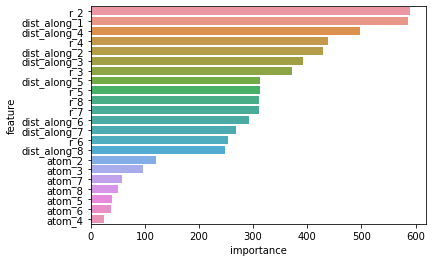

In [40]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

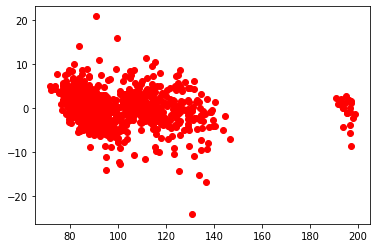

In [41]:
plt.plot(y_val, y_pred- y_val, 'ro')

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [42]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [43]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'lgb' #lgb  cat
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [44]:
categorical_features

['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [45]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
    '1JHC': 7,
    '1JHN': 7,    
    '2JHH': 7,
    '2JHN': 7,
    '2JHC': 7,
    '3JHH': 7,
    '3JHC': 7,
    '3JHN': 7
}


Checking cross-validation scores for each type:

In [ ]:
N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'dist_along_1',
       'dist_along_2', 'dist_along_3', 'dist_along_4', 'dist_along_5',
       'dist_along_6', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'dist_along_1',
       'dist_along_2', 'dist_along_3', 'dist_along_4', 'dist_along_5',
       'dist_along_6', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.859	valid_1's l1: 3.08175
[200]	training's l1: 2.53557	valid_1's l1: 2.80393
[300]	training's l1: 2.36818	valid_1's l1: 2.66377
[400]	training's l1: 2.25889	valid_1's l1: 2.60288
[500]	training's l1: 2.17113	valid_1's l1: 2.53843
[600]	training's l1: 2.10317	valid_1's l1: 2.51376
Did not meet early stopping. Best iteration is:
[600]	training's l1: 2.10317	valid_1's l1: 2.51376
1JHC Fold 0, logM

*** Training Model for 2JHC ***
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'dist_along_1',
       'dist_along_2', 'dist_along_3', 'dist_along_4', 'dist_along_5',
       'dist_along_6', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'dist_along_1',
       'dist_along_2', 'dist_along_3', 'dist_along_4', 'dist_along_5',
       'dist_along_6', 'r_2', 'r_3', 'r_4', 'r_5', 'r_6'],
      dtype='object')
Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 1.59669	valid_1's l1: 1.5853
[200]	training's l1: 1.46329	valid_1's l1: 1.4722
[300]	training's l1: 1.38116	valid_1's l1: 1.42361
[400]	training's l1: 1.32437	valid_1's l1: 1.38315
[500]	training's l1: 1.27829	valid_1's l1: 1.35422
[600]	training's l1: 1.23811	valid_1's l1: 1.32847
Did not meet early stopping. Best iteration is:
[600]	training's l1: 1.23811	valid_1's l1: 1.32847
2JHC Fold 0, logM

In [ ]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

And cv mean score:

In [ ]:
np.mean(list(cv_scores.values()))

Sanity check for all cells to be filled with predictions:

In [ ]:
submission[submission['scalar_coupling_constant'] == 0].shape

In [ ]:
submission.head(10)

In [ ]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')

## a!!!